### Multilayer Perceptron.

In this series of notebooks we will be going through image classification with pytorch and torchvision.

### Multilayer Perceptron, What is that?
Also known as a Feeed Forward Neural Network. In this notebook we will have a good understanding on image classsification using the `MNIST` dataset which contains images of digits from 0 to 9.

### Data Preparation.

In [46]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import random, time, copy
from prettytable import PrettyTable
import numpy as np
from torchvision import transforms, datasets
from torch.utils import data
from torch import nn

> Other modules we will import them as we go

### Setting seeds

In [2]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Loading our dataset.

We will load the `train` and `test` sets from the mnist in the following cell.

In [ ]:
train_data = datasets.MNIST(
    '.', train=True, download=True
)
test_data = datasets.MNIST(
    '.', train=False, download=True
)

### Data Normalization.
his means we want it to have a mean of zero and a standard deviation of one.

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

We normalize our data by subtracting the mean and dividing by the standard deviation of our dataset. First, we need to calculate the mean and standard deviation. Note: it is important that the mean and standard deviation are only calculated over the training set and not the test set. We do not want to use any information at all from the test set and should only look at it when we are calculating our test loss.

To calculate the means and standard deviations we get the actual data (the images) using the .data. attribute of our training data, convert them into floating point numbers and then use the built in mean and std functions to calculate the mean and standard deviation, respectively. The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.

In [4]:
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255

In [5]:
def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [7]:
tabulate([
    "Measure of Central Tendecy", "Value"
],[
   ("mean", mean),
   ("standard dev (std)", std)
], "THE MEAN AND STANDARD DEVIATION OF THE DATA")

+-----------------------------------------------+
|  THE MEAN AND STANDARD DEVIATION OF THE DATA  |
+-----------------------------+-----------------+
| Measure of Central Tendecy  |           Value |
+-----------------------------+-----------------+
| mean                        |  tensor(0.1307) |
| standard dev (std)          |  tensor(0.3081) |
+-----------------------------+-----------------+


### Data Transformation.
Now we have our mean and starndard deviation, how do we use it? You guess it right we use Torchvision `transforms` to transform our data. Note that if we have more than 1 transformation that we may want to perform we use `transform.Compose` to build a list of transforms. These are the transformation that we are going to apply to our images:

* `RandomRotation` - randomly rotates the image between (-x, +x) degrees, where we have set x = 5. Note the fill=(0,) is due to a bug in some versions of torchvision.
* `RandomCrop` - this first adds padding around our image, 2 pixels here, to artifically make it bigger, before taking a random 28x28 square crop of the image.
* `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
* `Normalize` - this subtracts the mean and divides by the standard deviations given.

**Note that some other transformation have to be applied before the other** For example the first 2 transformation have to be applied before `ToTensor()` transform and the `Normalize()` have to be applied after `ToTensor()`.

We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized.



In [11]:
train_transforms = transforms.Compose([
        transforms.RandomRotation(5, fill=(0, )),
        transforms.RandomCrop(28, padding=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std]
                             , inplace=False)
])

test_transforms = transforms.Compose([
         transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std]
                             , inplace=False)  
])

### Loading the data.

Now that we have our transforms we can load the data from our `.` root.

In [13]:
train_data = datasets.MNIST('.',
                            train= True,
                            download=True,
                            transform=train_transforms
                            )
test_data = datasets.MNIST('.', 
                           train=False,
                           download=True,
                           transform=test_transforms
                           )

### Checking examples.

In [17]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("train", len(train_data)), ("test", len(test_data))
tabulate(columns, data_rows, title)

+-------------------+
| DATASETS EXAMPLES |
+---------+---------+
| SET     |   TOTAL |
+---------+---------+
| train   |   60000 |
| test    |   10000 |
+---------+---------+


### Visualizing images that we are working with.

In [36]:
def plot_images(images, labels, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image.view(28, 28), cmap="gray")
        plt.title(label, color ='k', fontsize=16 )

In [33]:
images = [image for image, label in [train_data[i] for i in range(32)] ]
labels = [label for image, label in [train_data[i] for i in range(32)] ]

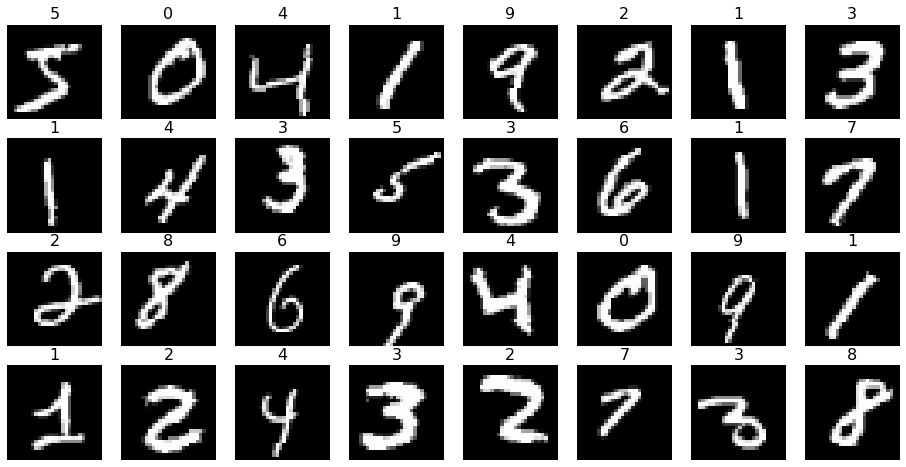

In [37]:
plot_images(images, labels, cols=8)

### `MNIST`.
MNIST dataset comes with only two sets, the `train` and the `test`. But during model training we also want some `validation` data. How are we going to get that. We are going to take `.1` fraction of the data from the `train`.

**Note**: The validation data should always come from the train set. Never ever take from the `test` set.

In [39]:
n_valid = int(len(train_data) * 0.1)
n_train = len(train_data) - n_valid

### Splitting the data.
Now we use the `random_split` to split randomly 10% from the train_data.

In [41]:
train_data, valid_data = data.random_split(train_data, [n_train, n_valid])

### Now Checking examples

In [42]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("training", len(train_data)), ("testing", len(test_data)), ("validation", len(valid_data))
tabulate(columns, data_rows, title)

+--------------------+
| DATASETS EXAMPLES  |
+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   | 54000 |
| testing    | 10000 |
| validation |  6000 |
+------------+-------+


### But why?
If we take a closer look we will notice that our validation data will have train transforms. In real world example it should not be like that. **The validation must represent the test data very well so that our training metrics wont be biased.**

We can simply replace the validation transforms by overwritting it with our test transforms from above. As the `validation` set is a `Subset` of the training set, if we change the `transforms` of one then by `default` `Torchvision` will change the `transforms` of the other. To stop this from happening we make a `deepcopy` of the validation data.

In [43]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

### Defining a `DataLoader`
Next, we'll define a DataLoader for each of the training/validation/test sets. We can iterate over these and they will yield batches of images and labels which we can use to train our model.

 We will only shuffle the training set as it will be used for `stochastic gradient descent` and we want the each batch to be different between epochs. As we aren't using the validation or test sets to update our model parameters they do not need to be shuffled. 
 
 
**Ideally, we want to use the biggest batch size that we can. The `64` here is relatively small and can be increased if our hardware can handle it.**


In [44]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )
valid_iterator = data.DataLoader(valid_data,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )
test_iterator = data.DataLoader(test_data,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )

### Defining Our Model.

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers.

<p align="center">
<img src="https://camo.githubusercontent.com/4ea6f9af98aa601d63f07172e953d66d851c9ad7/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f6d6c702d6d6e6973742e706e673f7261773d31"/>
</p>

Specifically, first we will flatten our 1x28x28 (1 color channel, 28 pixels height and width) image into a 784 element vector, also called 784 features. We flatten our input as MLPs cannot handle two or three dimensional data. Next, the 784 dimensional input is passed through the first hidden layer to transform it into 250 dimensions. Then, another hidden layer, which will transform it to 100 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten digits, 0 - 9, so need our output to be 10 dimensions.

The transformation between 784 to 250, 250 to 100 and 100 to 10 dimensions are done by Linear layers. These are also known as fully connected or affine layers. In these layers every element in one layer is connected to every element in the next. We can think of these elements as neurons as this architecture is inspired by how the human brain is made of millions of interconnected nodes, also called neurons.

Each connection between a neuron in one layer and a neuron in the next has a weight associated with it. The input to one neuron is sum of the weighted values of all neurons in the previous layer connected to it, plus a weighted bias term, where the bias value is always 1. The neuron then applies an activation function to this weighted sum. This activation function is a non-linear function that allows the neural network to learn non-linear functions between inputs and outputs.

We define our MLP below, which consists of three linear layers. We first take the input batch of images and flatten them so they can be passed into the linear layers. We then pass them through the first linear layer, input_fc, which calculates the weighted sum of the inputs, and then apply the ReLU (rectified linear unit) activation function elementwise. This result is then passed through another linear layer, hidden_fc, again applying the same activation function elementwise. Finally, we pass this through the final linear layer, output_fc. We return not only the output but also the second hidden layer as we will do some analysis on it later.

The ReLU activation function is a popular non-linear function that is simply $max(0, x)$, where $x$ is the weighted sum of the inputs to that neuron. Other activation functions used are hyperbolic tan (tanh) and sigmoid function, however ReLU is the most commonly used.

<p align="center">
  <img src="https://camo.githubusercontent.com/7ccb641c57e77326f6bac0f845448674b5fd4818/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f72656c752e706e673f7261773d31"/>
</p>

One thing to note is that we do not use an activation function on the input directly or on the output. You should never use activation functions directly on the input, i.e. F.relu(x). PyTorch combines activation functions to be applied on the output with the functions which calculate the loss, also known as error or cost, of a neural network. This is done for numerical stability.

Why did we choose hidden dimensions of 250 and 100 elements? Why did we only have two hidden layers? There is no magic formula to tell us how many layers to use and how many neurons to have in each layer and there is most probably a better set of values. However, the general idea is that neural networks extract features from data. Layers closer to the input learn to extract general features (e.g. lines, curves, edges), whilst later layers combine the features extracted from the previous layer into more high level features (e.g. the intersection of two lines making a cross, multiple curves make a circle). We force our neural network to learn these features by reducing the number of neurons in each layer. This way it has to learn to compress information by extracting only the useful and general features. Thus, we want a neural network with multiple layers and some sort of information compression (reduced number of neurons in subsequent layers).


In [47]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.input_fc = nn.Linear(input_dim, 250)
    self.hidden_fc = nn.Linear(250, 100)
    self.output_fc = nn.Linear(100, output_dim)

  def forward(self, x):
    # x = [batch size, height, width]
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    # x = [batch size, height * width]
    x = F.relu(self.input_fc(x)) # x = [batch size, 250]
    x = F.relu(self.hidden_fc(x)) # x = [batch size, 100]
    outputs = self.output_fc(x) # x = [batch_size, output_dim]
    return outputs, x


### Creating the `MLP` instance

In [48]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10
model = MLP(INPUT_DIM, OUTPUT_DIM)
model

MLP(
  (input_fc): Linear(in_features=784, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=10, bias=True)
)

### Checking how many parameters our model have.

In [50]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(model)

+-----------------------------------+
|          MODEL PARAMETERS         |
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     |    222,360 |
| trainable parameters |    222,360 |
+----------------------+------------+


### Training the model

We will create an optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

The basic training steps are:

* pass a batch of data through your model
* calculate the loss of your batch by comparing your model's predictions against the actual labels
* calculate the gradient of each of your parameters with respect to the loss
* update each of your parameters by subtracting their gradient multiplied by a small learning rate parameter.

In this `MLP` we will use `Adam` optimizer as our optimizer.

In [51]:
optimizer = torch.optim.Adam(model.parameters())

### We will then define our `criterion`.
Criterion is just a loss function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

**``CrossEntropyLoss``** both computes the `softmax` activation function on the supplied predictions as well as the actual loss via ``_negative log likelihood_``.

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between `0` and `1`, and together they all sum to `1`.

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$
$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$
If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$
If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$
So, intuitively, as your model's output corresponding to the correct class index increases your loss decreases.

In [52]:
criterion = nn.CrossEntropyLoss()

### Device



In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Model and Criterion to the device.

We use the `.to()` method to push anything to the device

In [54]:
model = model.to(device)
criterion = criterion.to(device)

### Accuracy function.
This function will calculate the accuray. It takes predicted values and real values and returns a fraction which will help us during training and evaluation to see how accurate the model has become.

In [55]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  return correct.float()/y.shape[0]

### The training loop.
The training loop will follow these steps:

* put our model into train mode with `model.train()`
* iterate over our dataloader, returning batches of (image, label)
* place the batch on to our GPU, if we have one
clear the gradients calculated from the last batch
* pass our batch of images, x, through to model to get predictions, y_pred
* calculate the loss between our predictions and the actual labels
* calculate the accuracy between our predictions and the actual labels
* calculate the gradients of each parameter
* update the parameters by taking an optimizer step
* update our metrics

**The reason we are putting the model in training mode is because some layers act differently when the model is on `train` and differently when the model is in `evaluation` mode.**


In [56]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()

    epoch_loss +=loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

The evaluation loop is similar to the training loop. The differences are:

* we put our model into evaluation mode with `model.eval()`
* we wrap the iterations inside a with torch.`no_grad()`
*we do not zero gradients as we are not calculating any
* we do not calculate gradients as we are not updating parameters
* we do not take an optimizer step as we are not calculating gradients

**`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the with block. As our model will not have to calculate gradients it will be faster and use less memory.**

In [57]:
def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### A function that tracks how long it takes to train a single epoch.

In [58]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Training the model.
During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

## A visualize training

In [65]:
def tabulate_training(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [69]:
EPOCHS = 10
best_valid_loss = float('inf')
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best-model.pt')
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  title = f"EPOCH {epoch+1:02}/{EPOCHS}"
  tabulate_training(column_names, data_rows, title)

+--------------------------------------------+
|                EPOCH 01/10                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.106 |   96.76% | 0:00:15.52 |
| Validation | 0.079 |   97.64% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 02/10                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.097 |   96.93% | 0:00:15.46 |
| Validation | 0.078 |   97.49% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 03/10                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      

### Evaluating the best model.

In [70]:
model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_training(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.049 |   98.35% |            |
+------+-------+----------+------------+


### Our model achives `~98%` accuracy on the test set.
We can improve this by tweeking some parameters.

### Examining the Model.

Now we've trained our model there's a few things we can look at. Most of these are simple exploratory analysis, but they can offer some insights into your model.

An important thing to do is check what examples your model gets wrong and ensure that they're reasonable mistakes.

The function below will return the model's predictions over a given dataset. It will return the inputs `(image)` the outputs `(model predictions)` and the `ground truth` labels.

In [71]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

We can then get these predictions and, by taking the index of the highest predicted probability, get the predicted labels.

In [72]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

Then, we can make a confusion matrix from our actual labels and our predicted labels.

In [73]:
from sklearn import metrics
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

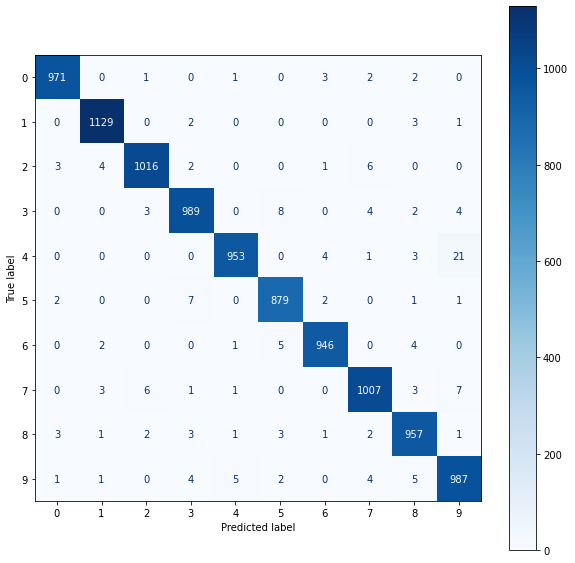

In [74]:
plot_confusion_matrix(labels, pred_labels)

The results seem reasonable enough, the most confused predictions-actuals are: 3-5 and 2-7.

Next, for each of our examples, we can check if our predicted label matches our actual label.

In [75]:
corrects = torch.eq(labels, pred_labels)

We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [76]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot the incorrectly predicted images along with how confident they were on the actual label and how confident they were at the incorrect label.

In [77]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

Below we can see the 25 images the model got incorrect and was most confident about.

A lot of these digits are irregular so it's difficult for the model to do well on these. The images that do look fine, if you squint you can sort of see why the model got it wrong.

Why is the neural network so confident on the irregular digits? Surely if it's a weird looking digit then the output of the softmax should be close to evenly distributed across a few digits the model isn't sure about, right? Well, no. The model has been trained to only be incredibly confident about its predictions and thus when it sees an image it will always be confident about what it is.

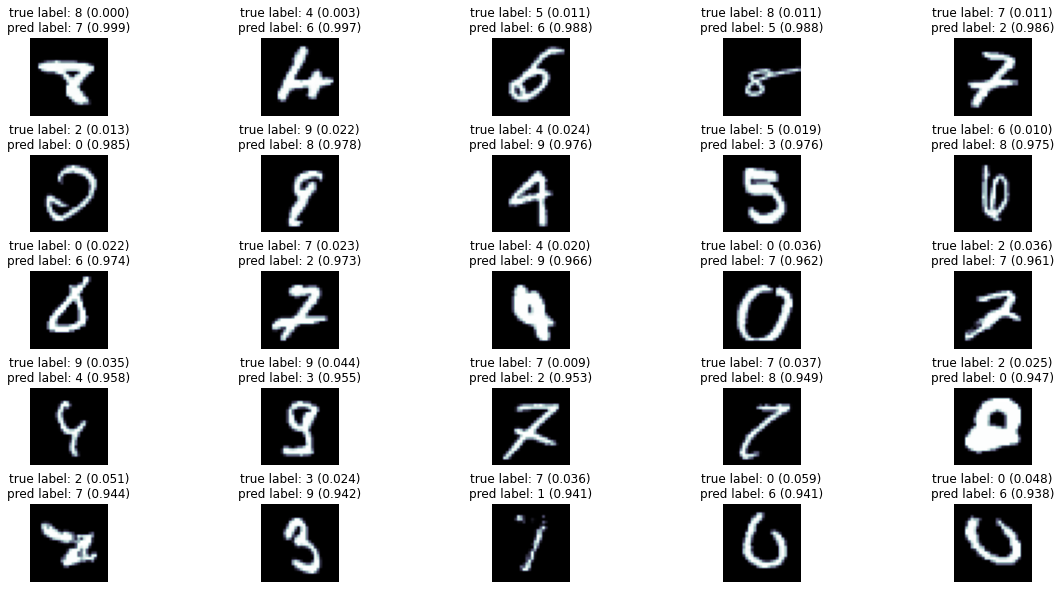

In [78]:
N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)

### We can actually perform a lot here.
Next we will look at `CNN` and evaluate on the `MNIST` dataset.

### Credits:
* [bentrevett](https://github.com/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb)